# Proposition : Stacking Ensemble Learning for network traffic prediction

Overleaf: https://www.overleaf.com/project/65a6aa4b76aff56ec51f05c1

## Imports

In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

## Dataset

In [ ]:
# @title Execution mode

# @markdown This jupyter notebook can either be run on Google colab or on a local machine.

# @markdown Please select your computation mode:
computation_mode = "Google Colab" # @param ["Google Colab", "Local"]

# @markdown If you chose `Local`computation mode, please specify the path to the dataset (with a CSV format).
path = "./" # @param {type:"string"}

if computation_mode == "Google Colab":
  print("Connecting to Google Drive...")
  from google.colab import drive

  # Drive connection
  drive.mount('/content/drive', force_remount=True)

  # Path when the files are in a shared drive
  path = '"/content/drive/Shareddrives/ING3 Recherche IA/"'

  # Move in directories
  %cd $path

else:
  print("Executing with local datas")

### Berlin V2X

Github : https://github.com/fraunhoferhhi/BerlinV2X?tab=readme-ov-file

Example usage : https://github.com/fraunhoferhhi/BerlinV2X/blob/main/ml5g-2023/reference_notebook.ipynb

In [ ]:
# Load the data
df = pd.read_parquet("berlin-v2x/cellular_dataframe.parquet")

# Drop duplicates
df = df.drop_duplicates()

# Filter only for downlink datarate measurements
filtered_data = df.query("direction == 'downlink' & measured_qos == 'datarate' & operator == 1")

# Remove incomplete measurements without datarate
filtered_data = filtered_data.dropna(subset=['datarate'])

# Define the columns to be used
qos_column = 'datarate'
feature_columns = [
     'PCell_RSRP_max',
     'PCell_RSRQ_max',
     'PCell_RSSI_max',
     'PCell_SNR_1',
     'PCell_SNR_2',
     'PCell_Downlink_Num_RBs',
     'PCell_Downlink_TB_Size',
     'PCell_Downlink_Average_MCS',
     'PCell_Downlink_bandwidth_MHz',
     'PCell_Cell_Identity',
     'PCell_freq_MHz',
     'SCell_RSRP_max',
     'SCell_RSRQ_max',
     'SCell_RSSI_max',
     'SCell_SNR_1',
     'SCell_SNR_2',
     'SCell_Downlink_Num_RBs',
     'SCell_Downlink_TB_Size',
     'SCell_Downlink_Average_MCS',
     'SCell_Downlink_bandwidth_MHz',
     'SCell_Cell_Identity',
     'SCell_freq_MHz',
     'Latitude',
     'Longitude',
     'Altitude',
     'speed_kmh',
     'COG',
     'precipIntensity',
     'precipProbability',
     'temperature',
     'apparentTemperature',
     'dewPoint',
     'humidity',
     'pressure',
     'windSpeed',
     'cloudCover',
     'uvIndex',
     'visibility',
     'Traffic Jam Factor']

# Get a DataFrame with only the required columns
filtered_data = filtered_data[feature_columns + [qos_column]]

filtered_data = filtered_data.dropna()

filtered_data.info()

# Train and test split
train_data, test_data = train_test_split(filtered_data, test_size=0.1, random_state=42)
x_train, y_train = train_data[feature_columns], train_data[qos_column]
x_test, y_test = test_data[feature_columns], test_data[qos_column]

# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print("Length of train dataset", len(x_train))
print("Length of test dataset", len(x_test))
print(f"The implementation uses {len(feature_columns)} features")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11546 entries, 2021-06-22 09:49:54+02:00 to 2021-06-24 18:59:59+02:00
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PCell_RSRP_max                11546 non-null  float64
 1   PCell_RSRQ_max                11546 non-null  float64
 2   PCell_RSSI_max                11546 non-null  float64
 3   PCell_SNR_1                   11546 non-null  float64
 4   PCell_SNR_2                   11546 non-null  float64
 5   PCell_Downlink_Num_RBs        11546 non-null  float64
 6   PCell_Downlink_TB_Size        11546 non-null  float64
 7   PCell_Downlink_Average_MCS    11546 non-null  float64
 8   PCell_Downlink_bandwidth_MHz  11546 non-null  object 
 9   PCell_Cell_Identity           11546 non-null  float64
 10  PCell_freq_MHz                11546 non-null  float64
 11  SCell_RSRP_max                11546 non-null  float64
 12  SCell_RSRQ_ma

## AI Model

### Auxiliary functions

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_residuals(x, y, models, stacking_regressor=None):
    # Ensure models is a list
    if not isinstance(models, list):
        models = [models]

    # Calculate residuals
    if stacking_regressor is not None:
        stacking_predictions = stacking_regressor.predict(x)
        estimators_predictions = stacking_regressor.transform(x)
        estimators_and_stacking_predictions = np.column_stack((estimators_predictions, stacking_predictions))
    else:
        estimators_predictions = np.column_stack([model[1].predict(x) for model in models])
        estimators_and_stacking_predictions = estimators_predictions

    residuals = estimators_and_stacking_predictions - np.expand_dims(y, axis=1)

    # Calculate R2, MSE, RMSE, and MAPE
    r2_scores = [r2_score(y, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]
    mse_scores = [mean_squared_error(y, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]
    rmse_scores = [int(np.sqrt(mse)) for mse in mse_scores]
    mape_scores = [mean_absolute_percentage_error(y, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]

    # Define labels and colors
    labels = [f'{model[0]} (R2: {r2:.5f}, RMSE: {rmse}, MAPE: {mape:.3f}%)' for model, r2, rmse, mape in zip(models, r2_scores, rmse_scores, mape_scores)]
    if stacking_regressor is not None:
        labels += [f'stacking_regressor (R2: {r2_scores[-1]:.5f}, RMSE: {rmse_scores[-1]}, MAPE: {mape_scores[-1]:.3f}%)']
    colors = plt.cm.rainbow(np.linspace(0, 1, residuals.shape[1]))

    # Create plot
    plt.figure(figsize=(10,6))
    for i in range(residuals.shape[1]):
        sns.kdeplot(residuals[:, i], color=colors[i], label=labels[i], linewidth=0.9)
    plt.xlabel('Residuals')
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()


def evaluation_metrics(x, y, models, stacking_regressor=None):
    # Ensure models is a list
    if not isinstance(models, list):
        models = [models]

    # Calculate residuals
    if stacking_regressor is not None:
        stacking_predictions = stacking_regressor.predict(x)
        estimators_predictions = stacking_regressor.transform(x)
        estimators_and_stacking_predictions = np.column_stack((estimators_predictions, stacking_predictions))
    else:
        estimators_predictions = np.column_stack([model[1].predict(x) for model in models])
        estimators_and_stacking_predictions = estimators_predictions

    residuals = estimators_and_stacking_predictions - np.expand_dims(y, axis=1)

    # Calculate R2, MSE, RMSE, and MAPE
    r2_scores = [r2_score(y, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]
    mse_scores = [mean_squared_error(y, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]
    rmse_scores = [int(np.sqrt(mse)) for mse in mse_scores]
    mape_scores = [mean_absolute_percentage_error(y, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]

    return r2_scores, mse_scores, rmse_scores, mape_scores

### Baseline : Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=50, random_state=1337, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=1337)

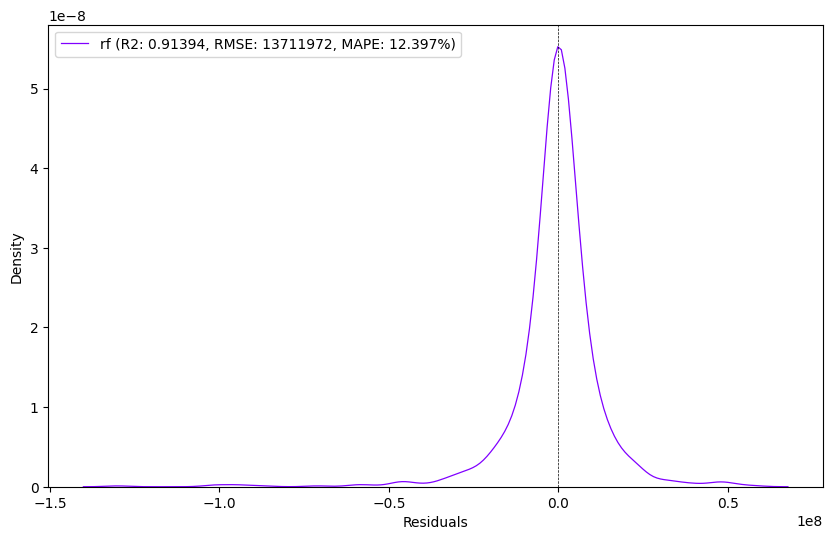

In [ ]:
plot_residuals(x_test, y_test, ('rf', rf))

### Stacking Ensemble Learning

#### Optimal model

In [ ]:
from sklearn.linear_model import OrthogonalMatchingPursuit, HuberRegressor, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

# Define the base models
estimators = [
    ('rf', RandomForestRegressor(random_state=1337, n_jobs=-1)),
    ('omp', OrthogonalMatchingPursuit()),
    ('gradient_boosting', GradientBoostingRegressor(random_state=1337)),
    ('nn', MLPRegressor(
          solver="lbfgs",
        )
    )
]

# Define the meta learner model
meta_model = LinearRegression()

# Define the stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_model, n_jobs=-1, verbose=1)

# Train the stacking regressor
stacking_regressor.fit(x_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(n_jobs=-1,
                                                     random_state=1337)),
                              ('omp', OrthogonalMatchingPursuit()),
                              ('gradient_boosting',
                               GradientBoostingRegressor(random_state=1337)),
                              ('nn', MLPRegressor(solver='lbfgs'))],
                  final_estimator=LinearRegression(), n_jobs=-1, verbose=1)

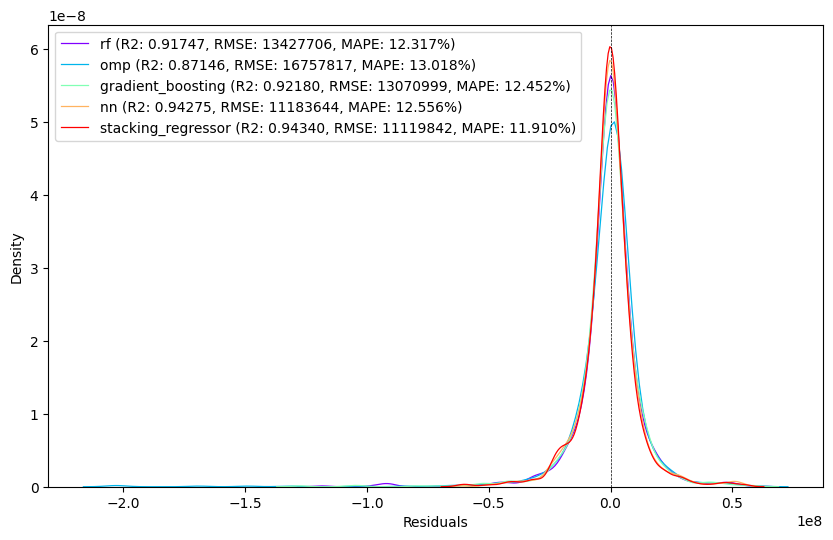

In [ ]:
plot_residuals(x_test, y_test, stacking_regressor.estimators, stacking_regressor)

#### Test models

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, BayesianRidge, PassiveAggressiveRegressor, HuberRegressor
from sklearn.linear_model import LinearRegression, LassoLars, OrthogonalMatchingPursuit, ARDRegression

# Define the base models
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=50, random_state=1337)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=50, random_state=1337)),
    ('ridge', Ridge(random_state=1337)),
    ('svr', SVR()),
    ('extra_trees', ExtraTreesRegressor(n_estimators=50, random_state=1337)),
    ('xgboost', XGBRegressor(n_estimators=50, random_state=1337)),
    ('lightgbm', LGBMRegressor(n_estimators=50, random_state=1337)),
    ('elastic_net', ElasticNet(random_state=1337)),
    ('knn', KNeighborsRegressor()),
    ('decision_tree', DecisionTreeRegressor(random_state=1337)),
    ('adaboost', AdaBoostRegressor(n_estimators=50, random_state=1337)),
    ('bagging', BaggingRegressor(n_estimators=50, random_state=1337)),
    ('mlp_regressor', MLPRegressor(random_state=1337, solver="lbfgs")),
    ('lasso', Lasso(random_state=1337)),
    ('bayesian_ridge', BayesianRidge()),
    ('passive_aggressive', PassiveAggressiveRegressor(random_state=1337)),
    ('huber', HuberRegressor()),
    ('lasso_lars', LassoLars()),
    ('omp', OrthogonalMatchingPursuit()),
    ('ard_regression', ARDRegression()),
]

# Define the meta learner model
meta_model = LinearRegression()

# Define the stacking regressor
stacking_regressor_test = StackingRegressor(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

# Train the stacking regressor
stacking_regressor_test.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingRegressor(estimators=[('random_forest',
                               RandomForestRegressor(n_estimators=50,
                                                     random_state=1337)),
                              ('gradient_boosting',
                               GradientBoostingRegressor(n_estimators=50,
                                                         random_state=1337)),
                              ('ridge', Ridge(random_state=1337)),
                              ('svr', SVR()),
                              ('extra_trees',
                               ExtraTreesRegressor(n_estimators=50,
                                                   random_state=1337)),
                              ('xgboost',
                               XGBRegressor(base_score=None, bo...
                               MLPRegressor(random_state=1337, solver='lbfgs')),
                              ('lasso', Lasso(random_state=1337)),
                              ('bayesian_ridge', BayesianRidge()),
                              ('passive_aggressive',
                               PassiveAggressiveRegressor(random_state=1337)),
                              ('huber', HuberRegressor()),
                              ('lasso_lars', LassoLars()),
                              ('omp', OrthogonalMatchingPursuit()),
                              ('ard_regression', ARDRegression())],
                  final_estimator=LinearRegression(), n_jobs=-1)

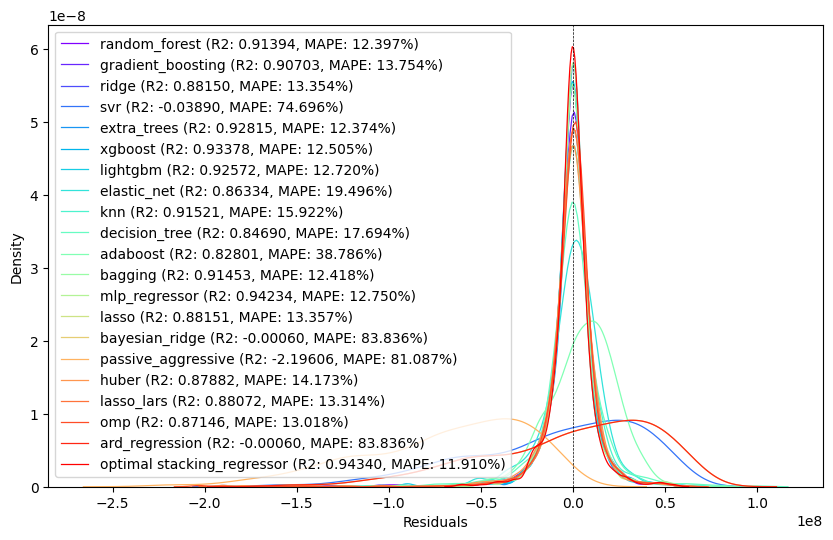

In [ ]:
# Calculate residuals and R2 scores
stacking_predictions = stacking_regressor.predict(x_test)
estimators_predictions = stacking_regressor_test.transform(x_test)
estimators_and_stacking_predictions = np.column_stack((estimators_predictions, stacking_predictions))
residuals = estimators_and_stacking_predictions - np.expand_dims(y_test, axis=1)
r2_scores = [r2_score(y_test, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]
mape_scores = [mean_absolute_percentage_error(y_test, estimators_and_stacking_predictions[:, i]) for i in range(estimators_and_stacking_predictions.shape[1])]

# Define labels and colors
labels = [f'{model[0]} (R2: {r2:.5f}, MAPE: {mape:.3f}%)' for model, r2,  mape in zip(base_models, r2_scores, mape_scores)] + [f'optimal stacking_regressor (R2: {r2_scores[-1]:.5f}, MAPE: {mape_scores[-1]:.3f}%)']
colors = plt.cm.rainbow(np.linspace(0, 1, residuals.shape[1]))

# Create plot
plt.figure(figsize=(10,6))
for i in range(residuals.shape[1]):
    sns.kdeplot(residuals[:, i], color=colors[i], label=labels[i], linewidth=0.9)
plt.xlabel('Residuals')
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

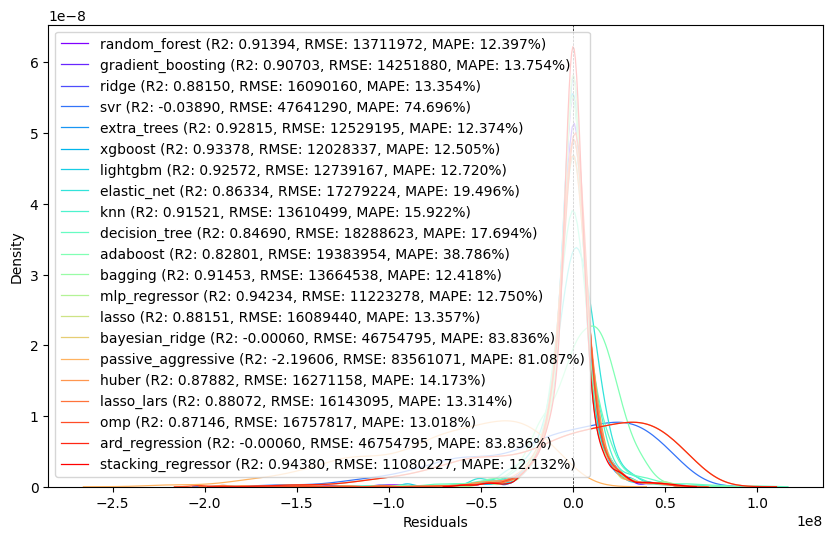

In [ ]:
hplot_residuals(x_test, y_test, stacking_regressor_test.estimators, stacking_regressor_test)

In [ ]:
r2, mse, rmse, mape = evaluation_metrics(x_test, y_test, [], stacking_regressor=stacking_regressor_test)
r2_sel, mse_sel, rmse_sel, mape_sel = evaluation_metrics(x_test, y_test, [("stacking_regressor",stacking_regressor)])
print("+----------------------+----------+------------+---------+")
for i,model in enumerate(stacking_regressor_test.estimators):
    print(f"| {model[0] :20} | {r2[i]: .5f} | {rmse[i]: 10} | {mape[i]: .3f} |")
    print("+----------------------+----------+------------+---------+")
print(f"| SEL                  | {r2_sel[0]: .5f} | {rmse_sel[0]: 10} | {mape_sel[0]: .3f} |")
print("+----------------------+----------+------------+---------+")


+----------------------+----------+------------+---------+
| random_forest        |  0.91394 |   13711972 |  12.397 |
+----------------------+----------+------------+---------+
| gradient_boosting    |  0.90703 |   14251880 |  13.754 |
+----------------------+----------+------------+---------+
| ridge                |  0.88150 |   16090160 |  13.354 |
+----------------------+----------+------------+---------+
| svr                  | -0.03890 |   47641290 |  74.696 |
+----------------------+----------+------------+---------+
| extra_trees          |  0.92815 |   12529195 |  12.374 |
+----------------------+----------+------------+---------+
| xgboost              |  0.93378 |   12028337 |  12.505 |
+----------------------+----------+------------+---------+
| lightgbm             |  0.92572 |   12739167 |  12.720 |
+----------------------+----------+------------+---------+
| elastic_net          |  0.86334 |   17279224 |  19.496 |
+----------------------+----------+------------+--------